In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
# Pkg.add("CUDA")
# Pkg.add("Glob")
# Pkg.add("Images")
# Pkg.add("FastAI")
# Pkg.add("FastVision")
# Pkg.add("Flux")
# Pkg.add("Metalhead")
# Pkg.add("Images")
# Pkg.add("DataAugmentation")
# Pkg.add("CairoMakie")
# Pkg.add("StaticArrays")
# Pkg.add("MLDataPattern")

  Activating project at `g:\桌面\2022 Fall\cs284A\Project`


In [2]:
using Glob
using CUDA
using FastAI
using FastVision
using MLDataPattern
using DataAugmentation, Images
using Flux
using Metalhead
using CairoMakie
using StaticArrays
using DICOM
using Images
using Printf
using NIfTI
using Base.Iterators
using Plots
CairoMakie.activate!(type="png")

# U-net for C1 -> C7 segmentation 

Locate files with mask

In [3]:
mask_dir = raw"D:\RSNA-2022-dataset\segmentations"
train_image_dir = raw"D:\RSNA-2022-dataset\train_images"

"D:\\RSNA-2022-dataset\\train_images"

In [4]:
mask_names = []
for f in readdir(mask_dir, join=false)
    push!(mask_names, splitext(f)[1])
end

Check if we found all images with mask and load

In [5]:
matched_names = []
ct = 0
for f in readdir(train_image_dir, join=false)
    if f in mask_names
        push!(matched_names, f)
        ct += 1
    end
end
println("Found $ct of $(size(mask_names)[1])")

Found 87 of 87


Load images and mask

In [6]:
image_size = (128, 128, 128)

(128, 128, 128)

In [7]:
container_images = Array{eltype(FastVision.Image)}(undef, image_size..., ct);
container_masks = Array{eltype(FastVision.Mask)}(undef, image_size..., ct);

Load 87 images from saved data.

In [25]:
Threads.@threads for i = 1 : 87
    curr_path = "G:\\桌面\\2022 Fall\\cs284A\\Project\\train\\"* string(i) * ".img"
    temp = zeros(128, 128, 128)
    read!(curr_path, temp)
    container_images[:,:,:, i] = deepcopy(temp)
end

In [27]:
i = 1
Threads.@threads for i = 1 : size(matched_names)[1]
    num_slices = size(readdir(train_image_dir * "\\" * matched_names[i]))[1]
    curr_image = zeros(num_slices, 512, 512)
    curr_mask = zeros(512, 512, num_slices)
    # read image
    curr_images_dcm_data_array = dcmdir_parse(train_image_dir * "\\" * matched_names[i])
    for slice = 1 : num_slices
        curr_image[slice, :, :] = curr_images_dcm_data_array[slice][(0x7fe0, 0x0010)]
    end
    curr_image = permutedims(curr_image, [3, 2, 1])
    # read mask
    curr_mask = niread(mask_dir * "\\" * matched_names[i] * ".nii")
    curr_mask = reverse(curr_mask; dims = 2)
    curr_mask = reverse(curr_mask; dims = 3)
    curr_mask = replace(x -> x>7 ? 0 : x, curr_mask)
    # Normalize
    curr_max, curr_min = maximum(curr_image), minimum(curr_image)
    curr_image = (curr_image .- curr_min) ./ (curr_max - curr_min);
    # Resize 
    container_images[:,:,:, i] = imresize(curr_image, image_size)
    container_masks[:,:,:, i] = round.(imresize(curr_mask, image_size))
    # println(i)
    # flush(stdout)
end

In [28]:
# Normalize
for i = 1 : 87
    open("G:\\桌面\\2022 Fall\\cs284A\\Project\\train\\"* string(i) * ".img", "w") do file
        write(file, string(container_images[:,:,:, i]))
    end
    # curr_img = container_images[:,:,:, i]
    # curr_max, curr_min = maximum(curr_img), minimum(curr_img)
    # curr_img = (curr_img .- curr_min) ./ (curr_max - curr_min)
    # container_images[:,:,:, i] = curr_img
end

In [29]:
container_images = Float32.(container_images);

In [30]:
container_masks = Int64.(container_masks .+ 1);

In [31]:
data = (container_images, container_masks)
# data = [(container_images[:,:,:,x], container_masks[:,:,:,x]) for x in 1:87];

In [32]:
maximum(container_images), minimum(container_images)

(1.0f0, 0.0f0)

In [33]:
maximum(container_masks), minimum(container_masks)

(8, 1)

In [34]:
image1, mask1 = sample = (container_images[:,:,:,1], container_masks[:,:,:,1]);

In [35]:
typeof(sample[1])

Array{Float32, 3}

In [36]:
typeof(sample[2])

Array{Int64, 3}

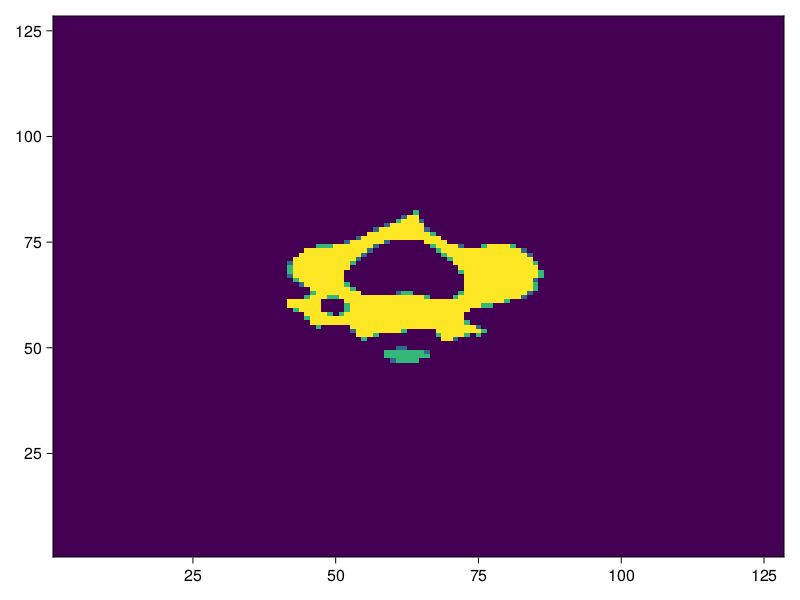

In [37]:
CairoMakie.heatmap(mask1[:, :, 60])

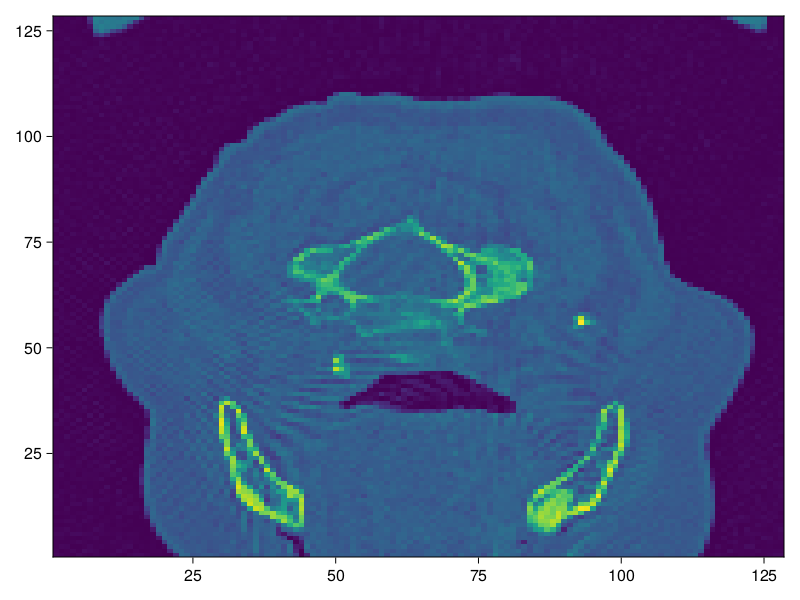

In [38]:
CairoMakie.heatmap(image1[:, :, 60])

In [39]:
data_mean, data_std = FastVision.imagedatasetstats(container_images, Gray{N0f8}) 
data_mean, data_std = StaticArraysCore.SVector{1, Float32}(data_mean[1]), StaticArraysCore.SVector{1, Float32}(data_std[1])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


(Float32[0.2771528], Float32[0.1556657])

Create a task

In [40]:
taskk = SupervisedTask(
    (FastVision.Image{3}(), Mask{3}(1:8)), # 7 classes and 1 background
    (
        FastVision.ProjectiveTransforms((image_size)),
        ImagePreprocessing(means = data_mean, stds = data_std, C = Gray{N0f8}),
        FastAI.OneHot()
    )
)

SupervisedTask(FastVision.Image{3} -> Mask{3, Int64})

In [41]:
checkblock(taskk.blocks.sample, sample)

true

In [42]:
train_files, val_files = MLDataPattern.splitobs(data, 0.8);

In [43]:
traindll, validdll = FastAI.taskdataloaders(train_files, val_files, taskk, 2);

Model

In [44]:
conv = (stride, in, out) -> Conv((3, 3, 3), in=>out, stride=stride, pad=(1, 1, 1))
tran = (stride, in, out) -> ConvTranspose((4, 4, 4), in=>out, stride=stride, pad=1)

conv1 = (in, out) -> Chain(conv(1, in, out), BatchNorm(out), x -> leakyrelu.(x))
conv2 = (in, out) -> Chain(conv(2, in, out), BatchNorm(out), x -> leakyrelu.(x))
tran2 = (in, out) -> Chain(tran(2, in, out), BatchNorm(out), x -> leakyrelu.(x))

#23 (generic function with 1 method)

In [45]:
function unet3D(in_chs, lbl_chs)
    # Contracting layers
    l1 = Chain(conv1(in_chs, 4))
    l2 = Chain(l1, conv1(4, 4), conv2(4, 16))
    l3 = Chain(l2, conv1(16, 16), conv2(16, 32))
    l4 = Chain(l3, conv1(32, 32), conv2(32, 64))
    l5 = Chain(l4, conv1(64, 64), conv2(64, 128))

    # Expanding layers
    l6 = Chain(l5, tran2(128, 64), conv1(64, 64))
    l7 = Chain(Parallel(+, l6, l4), tran2(64, 32), conv1(32, 32))       # Residual connection between l6 & l4
    l8 = Chain(Parallel(+, l7, l3), tran2(32, 16), conv1(16, 16))       # Residual connection between l7 & l3
    l9 = Chain(Parallel(+, l8, l2), tran2(16, 4), conv1(4, 4))          # Residual connection between l8 & l2
    l10 = Chain(l9, conv1(4, lbl_chs))
end

unet3D (generic function with 1 method)

In [46]:
model = unet3D(1, 8) |> gpu;

Loss function

In [ ]:
function _dice_kernel(f, x, y, l, thread_stride, j, b_max)
    index = threadIdx().x
	i = index + (blockIdx().x - 1i32) * thread_stride

    if i > l
		return
    end
	
    b_l = blockIdx().x == b_max ? l - (blockIdx().x - 1i32) * thread_stride : thread_stride
    cache = CuDynamicSharedArray(Float64, (thread_stride,))

	@inbounds cache[index] = x[i] * y[i]
		
    sync_threads()
    prev_mid = b_l
    while true
        mid = (prev_mid - 1i32) ÷ 2i32 + 1i32
        if index+mid <= prev_mid
            @inbounds cache[index] += cache[index+mid]
        end
        prev_mid = mid
        sync_threads()
        mid == 1i32 && break
    end
    
    if index == 1i32
        @inbounds CUDA.@atomic f[j] += cache[1]
    end
    return nothing
end

_dice_kernel (generic function with 1 method)

In [ ]:
function dice(ŷ::CuArray, y::CuArray; ϵ=1e-5)
	f = CuArray([0.0, 0.0])
	l = length(ŷ)
	
	k = @cuda launch=false _dice_kernel(f, ŷ, y, l, 0, 0, 0)
    GPU_threads = launch_configuration(k.fun).threads
	t = min(l, GPU_threads)
    b= cld(l, t)
	
    k(f, ŷ, y, l, t, 1, b; threads=t, blocks=b, shmem=t*8)
	k(f, ŷ, ŷ, l, t, 2, b; threads=t, blocks=b, shmem=t*8)
	k(f, y, y, l, t, 2, b; threads=t, blocks=b, shmem=t*8)

    f = Array(f)
    @inbounds return 1 - muladd(2, f[1], ϵ) / (f[2] + ϵ)
end

dice (generic function with 2 methods)

In [47]:
lossfn = tasklossfn(taskk)

_segmentationloss (generic function with 1 method)

Training

In [48]:
optimizer = ADAM() 
learner = Learner(model, lossfn; data=(traindll, validdll), optimizer, callbacks=[ToGPU()])

Learner()

In [49]:
fitonecycle!(learner, 10, 0.033)

Epoch 1 TrainingPhase(): 100%|██████████████████████████| Time: 0:10:59
Epoch 1 ValidationPhase(): 100%|████████████████████████| Time: 0:00:14
Epoch 2 TrainingPhase(): 100%|██████████████████████████| Time: 0:00:41
Epoch 2 ValidationPhase(): 100%|████████████████████████| Time: 0:00:08
Epoch 3 TrainingPhase(): 100%|██████████████████████████| Time: 0:00:43
Epoch 3 ValidationPhase(): 100%|████████████████████████| Time: 0:00:09
Epoch 4 TrainingPhase(): 100%|██████████████████████████| Time: 0:00:45
Epoch 4 ValidationPhase(): 100%|████████████████████████| Time: 0:00:09
Epoch 5 TrainingPhase(): 100%|██████████████████████████| Time: 0:00:49
Epoch 5 ValidationPhase(): 100%|████████████████████████| Time: 0:00:07
Epoch 6 TrainingPhase(): 100%|██████████████████████████| Time: 0:00:36
Epoch 6 ValidationPhase(): 100%|████████████████████████| Time: 0:00:05
Epoch 7 TrainingPhase(): 100%|██████████████████████████| Time: 0:00:34
Epoch 7 ValidationPhase(): 100%|████████████████████████| Time: 

┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │   1.0 │ 1.81044 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬────────┐
│             Phase │ Epoch │   Loss │
├───────────────────┼───────┼────────┤
│ ValidationPhase() │   1.0 │ 1.7769 │
└───────────────────┴───────┴────────┘
┌─────────────────┬───────┬────────┐
│           Phase │ Epoch │   Loss │
├─────────────────┼───────┼────────┤
│ TrainingPhase() │   2.0 │ 1.1095 │
└─────────────────┴───────┴────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │   2.0 │ 0.77497 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬────────┐
│           Phase │ Epoch │   Loss │
├─────────────────┼───────┼────────┤
│ TrainingPhase() │   3.0 │ 0.5943 │
└─────────────────┴───────┴────────┘
┌───────────────────┬───────┬─────────┐
│    

In [50]:
savetaskmodel("stage1_1.jld2", taskk, learner.model, force = true)

In [51]:
for i = 2:15
    fitonecycle!(learner, 10, 0.033)
    savetaskmodel("stage1_"*string(i)*".jld2", taskk, learner.model, force = true)
    println("$i saved.")
    flush(stdout)
end

Epoch 11 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:42
Epoch 11 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 12 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:43
Epoch 12 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 13 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:41
Epoch 13 ValidationPhase(): 100%|███████████████████████| Time: 0:00:09
Epoch 14 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:50
Epoch 14 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 15 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:35
Epoch 15 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 16 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:42
Epoch 16 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 17 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:35
Epoch 17 ValidationPhase(): 100%|███████████████████████| Time: 

┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  11.0 │ 0.13229 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │  11.0 │ 0.17031 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  12.0 │ 0.14181 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │  12.0 │ 0.35685 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  13.0 │ 0.14707 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─

Epoch 21 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:49
Epoch 21 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 22 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:40
Epoch 22 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 23 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:49
Epoch 23 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 24 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:42
Epoch 24 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 25 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:42
Epoch 25 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 26 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:45
Epoch 26 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 27 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:45
Epoch 27 ValidationPhase(): 100%|███████████████████████| Time: 

┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  21.0 │ 0.11211 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │  21.0 │ 0.18208 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  22.0 │ 0.12144 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │  22.0 │ 0.21085 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  23.0 │ 0.10979 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─

Epoch 31 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:41
Epoch 31 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 32 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:42
Epoch 32 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 33 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:42
Epoch 33 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 34 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:47
Epoch 34 ValidationPhase(): 100%|███████████████████████| Time: 0:00:06
Epoch 35 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:47
Epoch 35 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 36 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:50
Epoch 36 ValidationPhase(): 100%|███████████████████████| Time: 0:00:06
Epoch 37 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:41
Epoch 37 ValidationPhase(): 100%|███████████████████████| Time: 

┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  31.0 │ 0.10206 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │  31.0 │ 0.22904 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  32.0 │ 0.10145 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │  32.0 │ 0.18509 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  33.0 │ 0.10413 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─

Epoch 41 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:42
Epoch 41 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 42 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:48
Epoch 42 ValidationPhase(): 100%|███████████████████████| Time: 0:00:06
Epoch 43 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:42
Epoch 43 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 44 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:43
Epoch 44 ValidationPhase(): 100%|███████████████████████| Time: 0:00:09
Epoch 45 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:44
Epoch 45 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 46 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:34
Epoch 46 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 47 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:42
Epoch 47 ValidationPhase(): 100%|███████████████████████| Time: 

┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  41.0 │ 0.09621 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬────────┐
│             Phase │ Epoch │   Loss │
├───────────────────┼───────┼────────┤
│ ValidationPhase() │  41.0 │ 0.2264 │
└───────────────────┴───────┴────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  42.0 │ 0.09879 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │  42.0 │ 0.40269 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬────────┐
│           Phase │ Epoch │   Loss │
├─────────────────┼───────┼────────┤
│ TrainingPhase() │  43.0 │ 0.0955 │
└─────────────────┴───────┴────────┘
┌───────────────────┬───────┬─────────┐


Epoch 51 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:42
Epoch 51 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 52 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:45
Epoch 52 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 53 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:44
Epoch 53 ValidationPhase(): 100%|███████████████████████| Time: 0:00:06
Epoch 54 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:44
Epoch 54 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 55 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:34
Epoch 55 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 56 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:33
Epoch 56 ValidationPhase(): 100%|███████████████████████| Time: 0:00:04
Epoch 57 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:48
Epoch 57 ValidationPhase(): 100%|███████████████████████| Time: 

┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  51.0 │ 0.08445 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │  51.0 │ 0.31781 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  52.0 │ 0.08669 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │  52.0 │ 0.17548 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  53.0 │ 0.08358 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─

Epoch 61 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:34
Epoch 61 ValidationPhase(): 100%|███████████████████████| Time: 0:00:04
Epoch 62 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:34
Epoch 62 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 63 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:50
Epoch 63 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 64 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:44
Epoch 64 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 65 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:42
Epoch 65 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 66 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:43
Epoch 66 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 67 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:42
Epoch 67 ValidationPhase(): 100%|███████████████████████| Time: 

┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  61.0 │ 0.07305 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │  61.0 │ 0.09138 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬────────┐
│           Phase │ Epoch │   Loss │
├─────────────────┼───────┼────────┤
│ TrainingPhase() │  62.0 │ 0.0743 │
└─────────────────┴───────┴────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │  62.0 │ 0.09063 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  63.0 │ 0.07492 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬──────

Epoch 71 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:40
Epoch 71 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 72 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:33
Epoch 72 ValidationPhase(): 100%|███████████████████████| Time: 0:00:04
Epoch 73 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:42
Epoch 73 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 74 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:49
Epoch 74 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 75 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:34
Epoch 75 ValidationPhase(): 100%|███████████████████████| Time: 0:00:04
Epoch 76 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:40
Epoch 76 ValidationPhase(): 100%|███████████████████████| Time: 0:00:04
Epoch 77 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:46
Epoch 77 ValidationPhase(): 100%|███████████████████████| Time: 

┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  71.0 │ 0.06493 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │  71.0 │ 0.12527 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  72.0 │ 0.06784 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │  72.0 │ 0.08282 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  73.0 │ 0.07212 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─

Epoch 81 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:43
Epoch 81 ValidationPhase(): 100%|███████████████████████| Time: 0:00:09
Epoch 82 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:43
Epoch 82 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 83 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:46
Epoch 83 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 84 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:41
Epoch 84 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 85 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:43
Epoch 85 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 86 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:43
Epoch 86 ValidationPhase(): 100%|███████████████████████| Time: 0:00:06
Epoch 87 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:36
Epoch 87 ValidationPhase(): 100%|███████████████████████| Time: 

┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  81.0 │ 0.06033 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │  81.0 │ 0.09304 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  82.0 │ 0.06293 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │  82.0 │ 0.10695 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  83.0 │ 0.06433 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─

Epoch 91 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:43
Epoch 91 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 92 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:43
Epoch 92 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 93 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:41
Epoch 93 ValidationPhase(): 100%|███████████████████████| Time: 0:00:07
Epoch 94 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:42
Epoch 94 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 95 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:37
Epoch 95 ValidationPhase(): 100%|███████████████████████| Time: 0:00:04
Epoch 96 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:41
Epoch 96 ValidationPhase(): 100%|███████████████████████| Time: 0:00:08
Epoch 97 TrainingPhase(): 100%|█████████████████████████| Time: 0:00:36
Epoch 97 ValidationPhase(): 100%|███████████████████████| Time: 

┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  91.0 │ 0.06062 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬────────┐
│             Phase │ Epoch │   Loss │
├───────────────────┼───────┼────────┤
│ ValidationPhase() │  91.0 │ 0.0905 │
└───────────────────┴───────┴────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  92.0 │ 0.06134 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │  92.0 │ 0.07579 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │  93.0 │ 0.06027 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬──────

Epoch 101 TrainingPhase(): 100%|████████████████████████| Time: 0:00:43
Epoch 101 ValidationPhase(): 100%|██████████████████████| Time: 0:00:07
Epoch 102 TrainingPhase(): 100%|████████████████████████| Time: 0:00:50
Epoch 102 ValidationPhase(): 100%|██████████████████████| Time: 0:00:07
Epoch 103 TrainingPhase(): 100%|████████████████████████| Time: 0:00:42
Epoch 103 ValidationPhase(): 100%|██████████████████████| Time: 0:00:07
Epoch 104 TrainingPhase(): 100%|████████████████████████| Time: 0:00:33
Epoch 104 ValidationPhase(): 100%|██████████████████████| Time: 0:00:05
Epoch 105 TrainingPhase(): 100%|████████████████████████| Time: 0:00:49
Epoch 105 ValidationPhase(): 100%|██████████████████████| Time: 0:00:07
Epoch 106 TrainingPhase(): 100%|████████████████████████| Time: 0:00:41
Epoch 106 ValidationPhase(): 100%|██████████████████████| Time: 0:00:07
Epoch 107 TrainingPhase(): 100%|████████████████████████| Time: 0:00:33
Epoch 107 ValidationPhase(): 100%|██████████████████████| Time: 

┌─────────────────┬───────┬────────┐
│           Phase │ Epoch │   Loss │
├─────────────────┼───────┼────────┤
│ TrainingPhase() │ 101.0 │ 0.0554 │
└─────────────────┴───────┴────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │ 101.0 │ 0.09383 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬────────┐
│           Phase │ Epoch │   Loss │
├─────────────────┼───────┼────────┤
│ TrainingPhase() │ 102.0 │ 0.0578 │
└─────────────────┴───────┴────────┘
┌───────────────────┬───────┬─────────┐
│             Phase │ Epoch │    Loss │
├───────────────────┼───────┼─────────┤
│ ValidationPhase() │ 102.0 │ 0.07311 │
└───────────────────┴───────┴─────────┘
┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ TrainingPhase() │ 103.0 │ 0.05803 │
└─────────────────┴───────┴─────────┘
┌───────────────────┬───────┬─────────┐


Epoch 111 TrainingPhase(): 100%|████████████████████████| Time: 0:00:46
Epoch 111 ValidationPhase(): 100%|██████████████████████| Time: 0:00:07
Epoch 112 TrainingPhase(): 100%|████████████████████████| Time: 0:00:43
Epoch 112 ValidationPhase(): 100%|██████████████████████| Time: 0:00:08
Epoch 113 TrainingPhase(): 100%|████████████████████████| Time: 0:00:45
Epoch 113 ValidationPhase(): 100%|██████████████████████| Time: 0:00:08
Epoch 114 TrainingPhase(): 100%|████████████████████████| Time: 0:00:49
Epoch 114 ValidationPhase(): 100%|██████████████████████| Time: 0:00:07
Epoch 115 TrainingPhase(): 100%|████████████████████████| Time: 0:00:44
Epoch 115 ValidationPhase(): 100%|██████████████████████| Time: 0:00:07
Epoch 116 TrainingPhase(): 100%|████████████████████████| Time: 0:00:46
Epoch 116 ValidationPhase(): 100%|██████████████████████| Time: 0:00:07
Epoch 117 TrainingPhase(): 100%|████████████████████████| Time: 0:00:41
Epoch 117 ValidationPhase(): 100%|██████████████████████| Time: 

: 

: 